ddddd

In [ ]:
lets to import some useful libraries

<a href="https://colab.research.google.com/github/iammehdii/TaskAris/blob/NewBranchAris/TaskAreasFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
from imutils import paths
from tensorflow.keras import backend as K
import os
import random
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
from collections import OrderedDict 
from matplotlib import pyplot



In [164]:
########## Set variabels
# IMAGE_DIMS = (224, 224, 3)   # # if u want to use VGG  or ReSnet50 uncomment this line
# # IMAGE_DIMS = (299, 299, 3) # if u want to use InceptionV3 uncomment this line
IMAGE_DIMS = (224, 224, 3) 
## set input images directory to train and test. be carfule it should be unzipped
inputImageDirectory = '/content/drive/My Drive/2020-11-01-Data/2020-11-01' 
## set input images directory be carfule it should be unzipped. it containes new images for predicttion step. that add newly to task
inputImageDirectoryPredict = '/content/drive/My Drive/predictData'
## initial learning rate for optimization
INIT_LR = 0.01
# set epoch numbers
EPOCHS = 50
# Set Batch Size
BS = 20
# Set Num of output class
numClass = 6
# Set it to keep initial layers of model untrainable. be carefule about depth of ur model 
untrainableDepthOfModel = 170
## output path that best model will be saved in this path
modelCheckPointPath = '/content/drive/My Drive/checkPointResNetFinall'
## input images Labels
classNames = ['bulldog-french', 'chow', 'dingo', 'doberman', 'germanshepherd', 'husky']

In [86]:
## takes a parent folder which has all images and returned  image Paths
def findImagePath(inputImageDirectory):
  np.random.seed(0)
  imagePaths = sorted(list(paths.list_images(inputImageDirectory)))
  imagePaths = np.random.permutation(imagePaths)
  return imagePaths

In [87]:
######### reads images and converts images to array. also find labels for each image
def convertImageToArray(IMAGE_DIMS, imagePaths ):
  data = []
  labels = []
  for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = tf.keras.preprocessing.image.img_to_array(image)
    data.append(image)
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
  return data, labels


In [88]:
## this function takes source model like ResNet50 and makes new model. 
#INPUTS 
# model: source model like ResNet or VGG
# opt: optimizer object for compiling model
#nClass: number of classes
# OUTPUT
# model: created model


def makeCustomeModel(model,nClass):
  predictions0 = keras.layers.Dense(128, activation='softmax')(model.layers[-2].output)
  predictions2 = keras.layers.Dense(nClass, activation='softmax')(predictions0)
  model = tf.keras.Model(inputs=model.input, outputs=predictions2)
  return model


In [96]:
## this functions takes 3 inputs and make a callbacks_list which used for storing best models in specific address and specific name
def pathToSaveCheckpoint(filePath):
  if not os.path.exists(filePath):
    os.makedirs(filePath)
  checkpoint = keras.callbacks.ModelCheckpoint(filePath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]
  return filePath, callbacks_list

In [90]:
##### this function takes features and labels,... and learns the model. It 's Possible to choose learning with or without data augmentaion
# INPUTS:
# trainX: features 
# trainY : labels
# compiledModel: model, it should be compiled before passing to function
# batchSize: size of batch
# useAug: determine how to model learns (with or without data augmentation)
#callbacks_list: for storing only best trained model based on choosed parameter(val_accuracy or val loss)
def doTrain(trainX, trainY, compiledModel,callbacks_list,batchSize, useAug=False):
  model =compiledModel
   
  if useAug :
    (trainX, validationX, trainY, validationY) = train_test_split(trainX, trainY, test_size=0.1,
  random_state=40 )
    aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
      height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
      horizontal_flip=True, fill_mode="nearest")
    it =aug.flow(x= trainX, y= trainY,batch_size=batchSize)
    itValidation =aug.flow(x= validationX, y= validationY,batch_size=batchSize)

    H = model.fit_generator(it,epochs=EPOCHS,validation_data=itValidation,callbacks=callbacks_list)
  
  else:
    H = model.fit(x=trainX, y=trainY, batch_size=batchSize,
      validation_split= 0.1 ,
      steps_per_epoch=None,
      epochs=EPOCHS, verbose=1,callbacks=callbacks_list)

In [122]:

def doTest(model, testX, testY, batchSize):
  topLossDict = dict()
  predY = model.predict(x= testX,batch_size=batchSize)
  cateCrossEntropy = tf.keras.losses.CategoricalCrossentropy()
  for i in range(predY.shape[0]):
    testLoss  = cateCrossEntropy(testY[i], predY[i]).numpy()
    topLossDict[str(i)] = testLoss
  # print('top loss for test images\n', topLoss, '\n')
  print('confusion_matrix\n')
  print(metrics.confusion_matrix(testY.argmax(axis=1), predY.argmax(axis=1)),'\n')
  print('report\n')
  print(metrics.classification_report(testY.argmax(axis=1), predY.argmax(axis=1)))
  return topLossDict


In [93]:
## preprocess images and split data to train and test and oneHot tha labels
imagePaths = findImagePath(inputImageDirectory)
data, labels = convertImageToArray(IMAGE_DIMS, imagePaths)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.1, random_state=42)

In [94]:
## choose source model by setting NUMBER
# be carefule about IMAGE_DIMS(u set it before)
NUMBER = 1 
###################ResNet50
if NUMBER == 1:
  sourceModel = tf.keras.applications.ResNet50(
      include_top=True,
      weights="imagenet",
      # weights=None,
      input_shape=(IMAGE_DIMS[0],IMAGE_DIMS[1],3),
      pooling=True  )
########## InceptionV3
elif  NUMBER == 2:
  sourceModel = tf.keras.applications.InceptionV3(
      include_top=True,
      weights="imagenet",
      input_tensor=None,
      input_shape=(IMAGE_DIMS[0],IMAGE_DIMS[1],3),
      pooling=None,
      classes=6,
      classifier_activation="softmax"
  )
elif  NUMBER == 3:
###############VGG16
  sourceModel = keras.applications.vgg16.VGG16(include_top=True, input_shape = (IMAGE_DIMS[0],IMAGE_DIMS[1],3), weights="imagenet")
###freeze all layers in source model except BatchNormalization layer. also change momentum of these layers 
# decreasing  momentum helps us to have good preiction even few epochs
for layer in sourceModel.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
        layer.momentum = 0.01
    else:
        layer.trainable = False

In [97]:
#### make ur final model and compile it
opt = keras.optimizers.Adam(lr=INIT_LR)
finalModel = makeCustomeModel(sourceModel, numClass)
#### unfreeze last layers to have good convergence. 
for layer in finalModel.layers[untrainableDepthOfModel:]: ## change depth if u dont use Resnet. set trainable for layers end-10 :end
  layer.trainable = True
# finalModel.summary()
finalModel.compile(optimizer=opt, loss='categorical_crossentropy', 	metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [103]:
############# train model
##### if useAug == True then datat will be rotaed and flipped
pathToBestModel, callbacks_list = pathToSaveCheckpoint(modelCheckPointPath)
doTrain(trainX, trainY, finalModel, callbacks_list, BS, useAug=True)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 1.4655 - categorical_accuracy: 0.9873
Epoch 00001: val_loss improved from inf to 1.47207, saving model to /content/drive/My Drive/checkPointResNetFinall
INFO:tensorflow:Assets written to: /content/drive/My Drive/checkPointResNetFinall/assets
12/12 [==============================] - 145s 12s/step - loss: 1.4655 - categorical_accuracy: 0.9873 - val_loss: 1.4721 - val_categorical_accuracy: 0.9259
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.4482 - categorical_accuracy: 0.9873
Epoch 00002: val_loss did not improve from 1.47207
12/12 [==============================] - 120s 10s/step - loss: 1.4482 - categorical_accuracy: 0.9873 - val_loss: 1.4898 - val_categorical_accuracy: 0.8519
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.4276 - categorical_accuracy: 0.9958
Epoch 00003: val_loss improved from 1.47207 to 1.43542, saving model to /content/drive/My Drive/checkPointResNetFinal

KeyboardInterrupt: ignored

In [ ]:
### load the best model and Test it
## top loss on tets dataset save in topLossDict
loadedModel = tf.keras.models.load_model(pathToBestModel)
lossDict = doTest(loadedModel, testX, testY, BS)
topLossDict = OrderedDict(sorted(topLoss.items(),reverse= True)) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


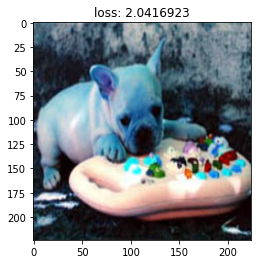

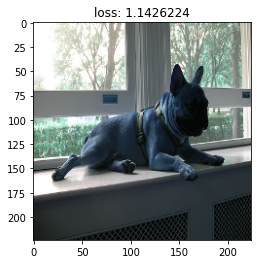

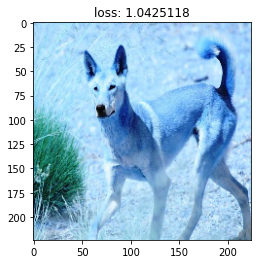

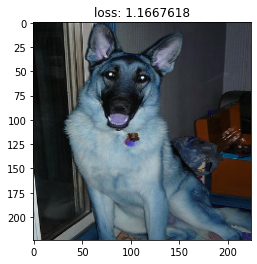

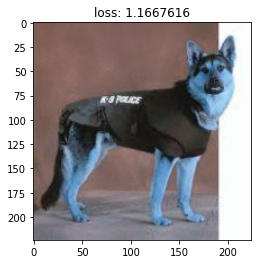

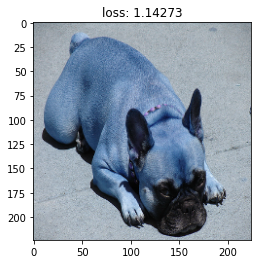

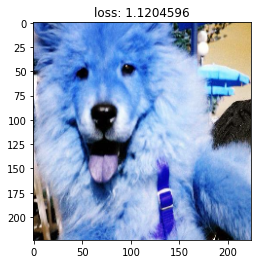

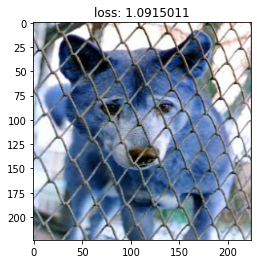

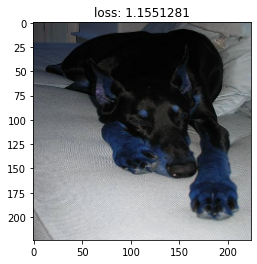

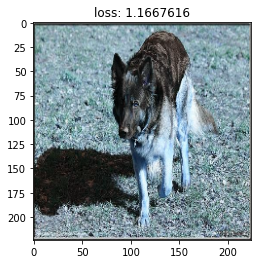

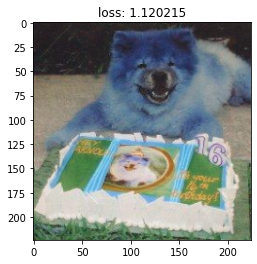

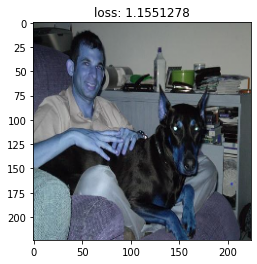

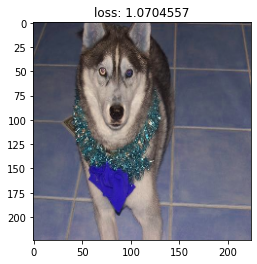

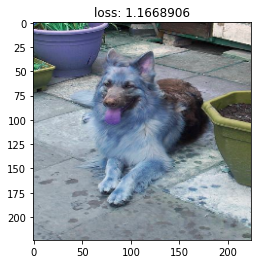

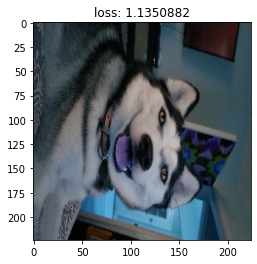

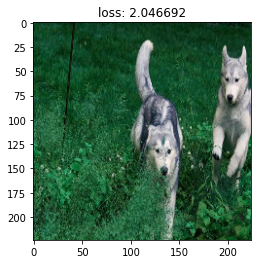

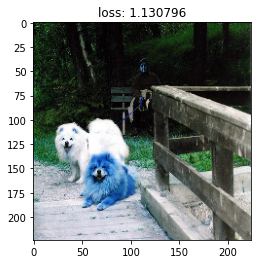

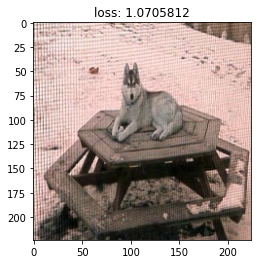

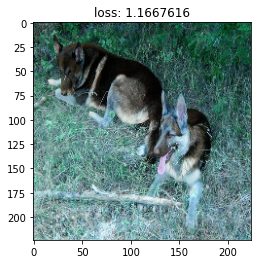

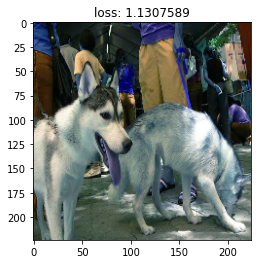

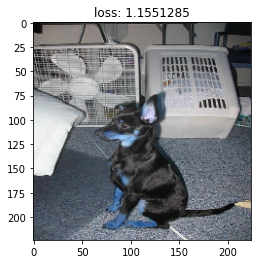

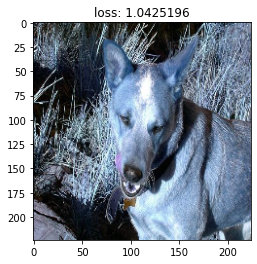

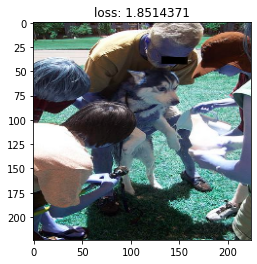

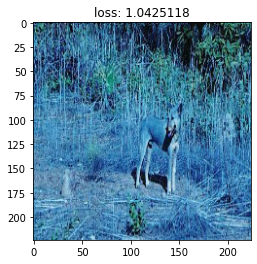

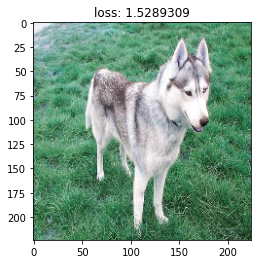

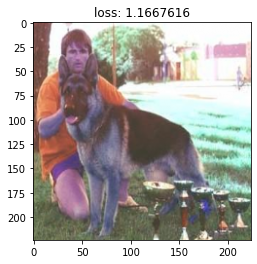

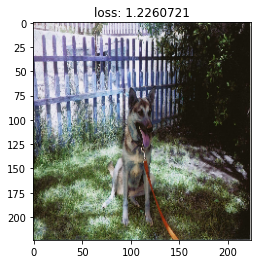

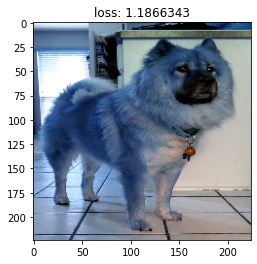

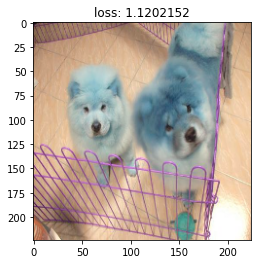

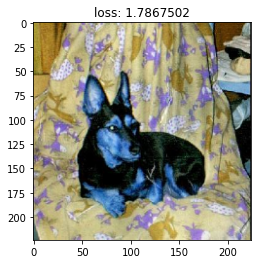

In [162]:
################# Plot test image and its correspond loss 
for key in topLossDict.keys():
  pyplot.figure()
  pyplot.title('loss: '+str(topLossDict[key]))
  key = int(key)
  # print(key)
  pyplot.imshow(testX[key])

In [165]:
################## Predict 

predictedClass = []
imageName = []
imagePaths = findImagePath(inputImageDirectoryPredict)
data,_= convertImageToArray(IMAGE_DIMS, imagePaths)
data = np.array(data, dtype="float") / 255.0
for image in imagePaths:
  name = image.split('/')[-1]
  imageName.append(name)
predY = loadedModel.predict(x= data,batch_size=20)
for i in range(len(imageName)):
  predictedClassName = classNames[predY[i].argmax(axis= 0)]
  predictedClass.append(predictedClassName)
# A = ['predicted class']
df = pd.DataFrame(predictedClass,index=imageName,columns=['predicted class'])
df

predicted class
n02115641_1380.jpg                    dingo
n02086240_1142.jpg                    husky
n02115641_3494.jpg                    dingo
n02107142_3236.jpg                 doberman
n02108915_4066.jpg           bulldog-french
n02112137_2845.jpg                     chow
n02107142_1193.jpg                 doberman
n02112018_1325.jpg                     chow
n02106662_3431.jpg           germanshepherd
n02086240_4127.jpg                     chow
n02106662_808.jpg            germanshepherd
n02112018_904.jpg                      chow
n02108915_3464.jpg           germanshepherd
n02107142_1306.jpg                 doberman
n02112137_2739.jpg                     chow
n02110185_353.jpg                     husky
n02086240_762.jpg            bulldog-french
IMG_20190826_121528_876.jpg  bulldog-french
n02112137_2020.jpg                     chow
n02110185_699.jpg                     husky